# Text Classification With Spacy

> Binary Classification i.e recommended vs non-recommended classes

1.  The classifier will detect recommended vs non-recommended video games.

2.  Training data: steam reviews

3.  Uses: to calculate the most recommended games


## Exploratory Data Analysis

In [1]:
import pandas as pd

steam_reviews_link = "https://gitlab.com/webdevcaptain/nlp-review/-/raw/main/data/steam-reviews.csv?ref_type=heads"

df = pd.read_csv(steam_reviews_link)

df.head()

,review_id,title,year,user_review,user_suggestion
0,1,Spooky's Jump Scare Mansion,2016.0,I'm scared and hearing creepy voices. So I'll...,1
1,2,Spooky's Jump Scare Mansion,2016.0,"Best game, more better than Sam Pepper's YouTu...",1
2,3,Spooky's Jump Scare Mansion,2016.0,"A littly iffy on the controls, but once you kn...",1
3,4,Spooky's Jump Scare Mansion,2015.0,"Great game, fun and colorful and all that.A si...",1
4,5,Spooky's Jump Scare Mansion,2015.0,Not many games have the cute tag right next to...,1


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17494 entries, 0 to 17493
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   review_id        17494 non-null  int64  
 1   title            17494 non-null  object 
 2   year             17316 non-null  float64
 3   user_review      17494 non-null  object 
 4   user_suggestion  17494 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 683.5+ KB


In [3]:
df.isnull().sum()

,0
review_id,0
title,0
year,178
user_review,0
user_suggestion,0


In [4]:
# Extract out just the useful data points for our sentiment analysis

df = df[['user_review', 'user_suggestion']].dropna()

df.head()

,user_review,user_suggestion
0,I'm scared and hearing creepy voices. So I'll...,1
1,"Best game, more better than Sam Pepper's YouTu...",1
2,"A littly iffy on the controls, but once you kn...",1
3,"Great game, fun and colorful and all that.A si...",1
4,Not many games have the cute tag right next to...,1


In [5]:
df.count()

,0
user_review,17494
user_suggestion,17494


In [6]:
df['user_suggestion'].value_counts() # Binary 💡

,count
user_suggestion,
1,9968
0,7526


Let's check the data distribution visually

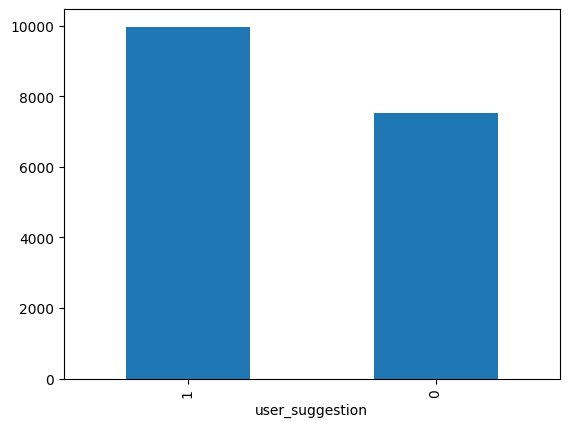

In [7]:
df['user_suggestion'].value_counts().plot(kind='bar');

In [8]:
!pip install spacy-lookups-data

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 8.9 MB/s eta 0:00:00


## Spacy pipeline for Text classification

In [9]:
import spacy

spacy.__version__

'3.7.5'

In [10]:
nlp = spacy.load("en_core_web_sm")

In [11]:
from spacy.lookups import Lookups

lookups = Lookups()
lookups.add_table("lexeme_norm", {})  # add required lookup tables

nlp.vocab.lookups = lookups

In [12]:
nlp.pipe_names

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']

### Text categorization pipeline

In [13]:
config = {
    "threshold": 0.5,  # or some other appropriate threshold
    "model": {
        "@architectures": "spacy.TextCatBOW.v3",
        "exclusive_classes": True,
        "ngram_size": 1,
        "no_output_layer": False
    }
}

textcat = nlp.create_pipe("textcat", config=config)

In [14]:
nlp.add_pipe("textcat", last=True)

nlp.pipe_names

['tok2vec',
 'tagger',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'ner',
 'textcat']

### Adding Labels

In [15]:
recommended_label = "RECOMMENDED"
not_recommended_label = "DON'T BUY THIS"

textcat.add_label(recommended_label)
textcat.add_label(not_recommended_label)

1

In [16]:
textcat.labels

('RECOMMENDED', "DON'T BUY THIS")

In [17]:
# Another way to modify the pipeline (individual pipe's config)

nlp.get_pipe('textcat').add_label(recommended_label)
nlp.get_pipe('textcat').add_label(not_recommended_label)

1

Some data transformation is needed here, just creating a new column based on existing columns

In [18]:
df['tuples'] = df.apply(lambda row: (row['user_review'], row['user_suggestion']), axis=1)

df

,user_review,user_suggestion,tuples
0,I'm scared and hearing creepy voices. So I'll...,1,(I'm scared and hearing creepy voices. So I'l...
1,"Best game, more better than Sam Pepper's YouTu...",1,"(Best game, more better than Sam Pepper's YouT..."
2,"A littly iffy on the controls, but once you kn...",1,"(A littly iffy on the controls, but once you k..."
3,"Great game, fun and colorful and all that.A si...",1,"(Great game, fun and colorful and all that.A s..."
4,Not many games have the cute tag right next to...,1,(Not many games have the cute tag right next t...
...,...,...,...
17489,Arguably the single greatest mmorp that exists...,1,(Arguably the single greatest mmorp that exist...
17490,"An older game, to be sure, but has its own cha...",1,"(An older game, to be sure, but has its own ch..."
17491,When I frist started playing Everquest 2 it wa...,1,(When I frist started playing Everquest 2 it w...
17492,cool game. THe only thing that REALLY PISSES M...,1,(cool game. THe only thing that REALLY PISSES ...


In [19]:
df['tuples'][0]

("I'm scared and hearing creepy voices.  So I'll pause for a moment and write a review while I wait for my heart beat to return to atleast somewhat calmer times.  This game is adorable and creepy like my happy tree friends but with the graphics sceme of my childhood (but more bubble and 'clean').  Hello 1990's.What charactes there are (that isnot trying to kill me) were likable and a bit odd.  I did do a few noob things though, such as:Oh look a class room full of ghosts from dead children, lets shine my flashlight on them and stand there staring at them..Or, hmm creepy music, I'll turn around and see if I can see what's chasing me.Never before in a game have I been this afraid of finding a locked door.",
 1)

In [20]:
df['tuples'][16995]

('Product received for freeEarly Access ReviewBug, i can not start the game. Improvement suggestion:1. walking2. mini map apperance3. color of items no need for color coded item to identify the rarity something.4. run boost item. better if like a real life game.5. Guns respawnNo idea?Why with gaijin? what the purpose please answerobservation on my first game.',
 0)

In [21]:
train = df['tuples'].tolist()

train[:2]

[("I'm scared and hearing creepy voices.  So I'll pause for a moment and write a review while I wait for my heart beat to return to atleast somewhat calmer times.  This game is adorable and creepy like my happy tree friends but with the graphics sceme of my childhood (but more bubble and 'clean').  Hello 1990's.What charactes there are (that isnot trying to kill me) were likable and a bit odd.  I did do a few noob things though, such as:Oh look a class room full of ghosts from dead children, lets shine my flashlight on them and stand there staring at them..Or, hmm creepy music, I'll turn around and see if I can see what's chasing me.Never before in a game have I been this afraid of finding a locked door.",
  1),
 ("Best game, more better than Sam Pepper's YouTube account. 10/10What you'll need to play:A computerSome extra pants.Pros:Scary as hell.Fun.Adventure.Spooky.Did I forgot to mention that its scary as hell?You'll get more pants/briefs in your wardrobe.Time consuming if you're bo

### Data loader

This implementation is highly inefficient and we should use sklearn for splitting data.

In [22]:
import random

def load_data(split=0.8, train=train):
  train_data = train

  random.shuffle(train_data)

  texts, labels = zip(*train_data)

  # print(type(texts), type(labels))

  cats = [
    {f'{recommended_label}': bool(y), f'{not_recommended_label}': not bool(y)} for y in labels
  ]

  split = int(len(train_data) * split)

  return (texts[:split], cats[:split]), (texts[split:], cats[split:])

In [23]:
(train_texts, train_cats), (validation_texts, validation_cats) = load_data()

train_data = list(zip(train_texts, [{'cats': cats} for cats in train_cats]))

train_data[:2]

[('I cannot get this game to launch properly on the Oculus, or at all, attempting to ignore a VR launch only results in a continued attempted VR launch by the program. I cannot wait to play this but I am stuck with a grey screen on launch. Does anyone have a solution to this?',
  {'cats': {'RECOMMENDED': True, "DON'T BUY THIS": False}}),
 ('hi im from the future/ escape from tarkov.do yourself a favor and dont ever EVER play a game with russian developers. also gaijin gives out all kinds of crap to people whoring themselves out for reviews. dont trust the tons of positive reviews especially ones from people with high hours.The game was bordering on mixed reviews with most of the negative reviews coming from many man players with 500-1000+ hours leaving negative reviews until gaijin began their propaganda campaign. but noooo we need to curate the people leaving steam reviews huh steam..gg gaming.',
  {'cats': {'RECOMMENDED': False, "DON'T BUY THIS": True}})]

In [24]:
validation_data = list(zip(validation_texts, [{'cats': cats} for cats in validation_cats]))

## Training a spacy model

In [25]:
from spacy.util import minibatch, compounding
from spacy.training.example import Example

n_iter = 3

other_pipes = [p for p in nlp.pipe_names if p != 'textcat']

with nlp.disable_pipes(*other_pipes):
  optimzer = nlp.begin_training()

  print("Starting to train a spacy base model with custom data")

  for i in range(n_iter):
    print(f"Epoch {i}")
    losses = {}

    # Always shuffle training data each epoch and use minibatches to stabilize training.
    batches = minibatch(train_data, size=compounding(4., 32., 1.001))

    for batch in batches:
      texts, annotations = zip(*batch)

      # nlp.update(texts, annotations, sgd=optimzer, drop=0.2, losses=losses)
      examples = [
          Example.from_dict(nlp.make_doc(text), ann) for text, ann in zip(texts, annotations)
      ]

      # Using dropout (here set to 20%) to avoid overfitting
      nlp.update(examples, sgd=optimzer, drop=0.2, losses=losses)

Starting to train a spacy base model with custom data
Epoch 0
Epoch 1
Epoch 2


## Validating on unseen data

In [26]:
review="the game was boring and we did not have any fun at all - I was very much so dissapointed"

doc = nlp(review)

doc.cats

{'RECOMMENDED': 0.00011717672896338627, "DON'T BUY THIS": 0.9998828172683716}

In [27]:
new_review="the game was long and it was not too bad but i had much better expectations and it's sad to say - I would not buy this game if I were you"

doc = nlp(new_review)

doc.cats

{'RECOMMENDED': 0.00034296762896701694, "DON'T BUY THIS": 0.9996570348739624}

In [28]:
new_review="best exciting flight simulator EVER!!!!!"

doc= nlp(new_review)

doc.cats

{'RECOMMENDED': 0.9999983310699463, "DON'T BUY THIS": 1.6242381661868421e-06}

In [29]:
new_review="wow it was awesome!!!! i showed all my friends!! i did not regret spending money on this game!"
doc = nlp(new_review)
doc.cats

{'RECOMMENDED': 0.9458870887756348, "DON'T BUY THIS": 0.054112885147333145}

In [30]:
new_review="It is not a good game, we thought we would have more fun but it was too long and we never finished till the end. I admit it was more fun than the first part reeased last year"

doc = nlp(new_review)

doc.cats

{'RECOMMENDED': 0.3729829490184784, "DON'T BUY THIS": 0.627017080783844}

In [31]:
from sklearn.metrics import precision_recall_fscore_support

def evaluate(nlp, examples):
    texts = [ex.reference.text for ex in examples]
    true_labels = [max(ex.reference.cats, key=ex.reference.cats.get) for ex in examples]
    docs = list(nlp.pipe(texts))
    pred_labels = [max(doc.cats, key=doc.cats.get) for doc in docs]
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average="weighted")
    return precision, recall, f1

In [32]:
validation_examples = [
    Example.from_dict(nlp.make_doc(text), ann) for text, ann in validation_data
]

validation_examples[0]

{'doc_annotation': {'cats': {'RECOMMENDED': False, "DON'T BUY THIS": True}, 'entities': ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], 'spans': {}, 'links': {}}, 'token_annotation': {'ORTH': ['It', "'s", 'basically', 'the', 'exact', 'same', 'thing', 'as', 'every', 'other', 'clicker', 'game', ',', 'except', 'this', 'time', ',', 'it', "'s", 'anime', '.', 'Also', ',', 'mechanically', ',', 'it', "'s", 'objectively', 'the', 'worst', 'in', 'every', 'single', 'way', '.', 'So', ',', 'if', 'you', 'like', '♥', '♥', '♥', '♥', '♥', '♥', 'games', 'BUT', 'it', 'also', 'has', 'to', 'be', 'the', '♥', '♥', '♥', '♥', '♥', 'iest', 'one', 'in', 't

In [33]:
precision, recall, f1 = evaluate(nlp, validation_examples)

print(f"Model scores | P: {precision:.3f} R: {recall:.3f} F1: {f1:.3f}")

Model scores | P: 0.864 R: 0.864 F1: 0.864


In [34]:
# Save the model to a directory
output_dir = "sentiment_model"

nlp.to_disk(output_dir)

print("Model saved to", output_dir)

Model saved to sentiment_model


In [35]:
# Load the model in a new variable
nlp2 = spacy.load(output_dir)

# Re-evaluate the loaded model on the validation set
precision, recall, f1 = evaluate(nlp2, validation_examples)

print(f"Loaded Model | P: {precision:.3f} R: {recall:.3f} F1: {f1:.3f}")

Loaded Model | P: 0.864 R: 0.864 F1: 0.864
